In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from src.labeling import get_daily_vol, get_events, get_bins

In [3]:
# 1. Charger les données traitées (processed)
df = pd.read_parquet('../data/processed/train_stationary.parquet')

In [4]:
# FORCE l'index à être un entier
df.index = df.index.astype(int)

# Vérifie que t1 est aussi propre
t1 = df.index.searchsorted(df.index + 5)
t1 = t1[t1 < df.shape[0]]
t1 = pd.Series(df.index[t1], index=df.index[:t1.shape[0]])
# FORCE t1 à être entier (normalement c'est auto, mais on blinde)
t1 = t1.astype(int)

In [5]:
# Pour les calculs de barrière, on a besoin d'un proxy de "Prix".
# Comme Hull Tactical prédit le S&P500, on peut reconstruire un indice synthétique
# à partir des rendements fournis ('forward_returns').
# Formule: Prix_t = Prix_t-1 * (1 + ret)
df['synthetic_price'] = (1 + df['forward_returns']).cumprod()

In [6]:
# 2. Calculer la Volatilité Dynamique (Snippet 3.1)
# C'est ce qui va définir l'épaisseur de nos barrières.
daily_vol = get_daily_vol(df['synthetic_price'], span0=50)

In [7]:
# 3. Définir les Barrières Verticales (Temps)
# La compétition demande une prévision à 1 jour (daily returns).
# Mais pour l'entraînement, on peut se donner un peu d'air.
# Disons qu'on laisse 5 jours max au trade pour réussir.
t1 = df.index.searchsorted(df.index + 5) # +5 index (jours)
t1 = t1[t1 < df.shape[0]]
t1 = pd.Series(df.index[t1], index=df.index[:t1.shape[0]])

In [8]:
# 4. Meta-Labeling : Définir un Modèle Primaire
# Pour cet exemple, prenons un signal très simple comme modèle primaire :
# "Si le rendement 'Market Excess' d'hier était positif, on parie à la hausse".
# (Dans la réalité, tu peux utiliser une moyenne mobile ici).
primary_signal = np.sign(df['market_forward_excess_returns'])
primary_signal = primary_signal.replace(0, 1) # Pas de neutre

In [9]:
# 5. Générer les Événements (Triple Barrier)
# pt_sl = [1, 1] -> On prend profit à 1x la volatilité, on coupe à 1x la volatilité.
# min_ret = 0.005 -> On ignore les situations où la volatilité est < 0.5% (bruit).
events = get_events(
    close=df['synthetic_price'],
    t_events=df.index, 
    pt_sl=[1, 1], 
    trgt=daily_vol, 
    min_ret=0.005, 
    t1=t1, 
    side=primary_signal
)

In [10]:
# 6. Obtenir les Labels Finaux
labels = get_bins(events, df['synthetic_price'])

print("Distribution des Labels (0 = Échec du modèle primaire, 1 = Succès):")
print(labels['bin'].value_counts())

Distribution des Labels (0 = Échec du modèle primaire, 1 = Succès):
bin
0.0    963
1.0    954
Name: count, dtype: int64


In [11]:
# Sauvegarder pour l'entraînement
labels.to_parquet('../data/processed/labels.parquet')

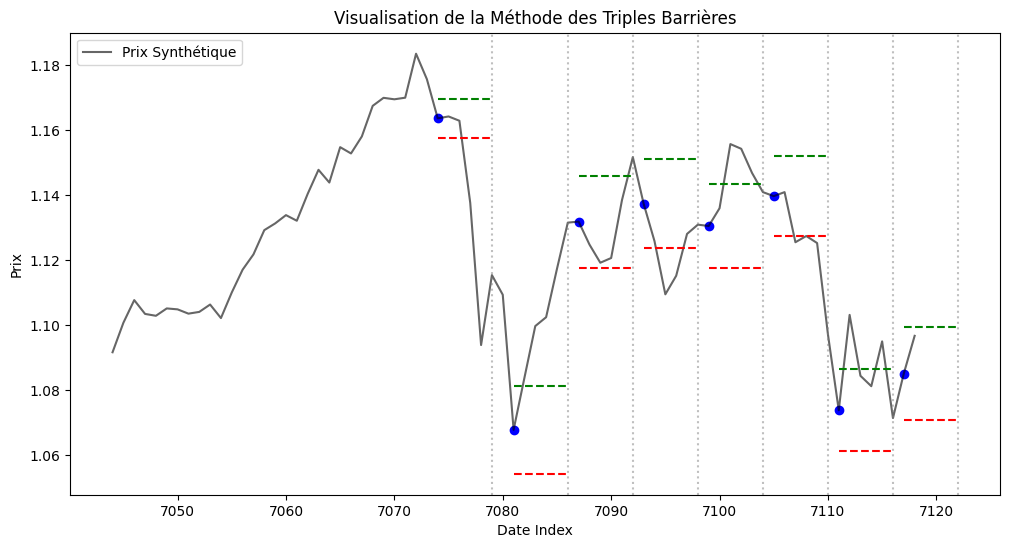

In [24]:
import matplotlib.pyplot as plt

# On prend un échantillon de 100 jours pour la lisibilité
sample_start = 75
sample_end = 150
idx_segment = df.index[sample_start:sample_end]
price_segment = df.loc[idx_segment, 'synthetic_price']

plt.figure(figsize=(12, 6))
plt.plot(idx_segment, price_segment, color='black', alpha=0.6, label='Prix Synthétique')

# Afficher quelques événements (Triple Barrier)
# On filtre les événements qui ont lieu dans notre fenêtre
subset_events = events[(events.index >= idx_segment[0]) & (events.index <= idx_segment[-1])]

for t0, row in subset_events.iloc[::6].iterrows():
    t1 = row['t1']
    trgt = row['trgt']
    
    # Niveau de prix initial
    p0 = df.loc[t0, 'synthetic_price']
    
    # Barrière Haut (Take Profit) & Bas (Stop Loss) - Exemple symétrique
    # Attention : Adaptez selon votre pt_sl (ici supposé symétrique pour l'exemple visuel)
    upper_barrier = p0 * (1 + trgt)
    lower_barrier = p0 * (1 - trgt)
    
    # Ligne Verticale (Barrière Temps)
    plt.axvline(x=t1, color='gray', linestyle=':', alpha=0.5)
    
    # Boite (Barrières horizontales)
    plt.hlines(y=[upper_barrier, lower_barrier], xmin=t0, xmax=t1, colors=['green', 'red'], linestyles='--')
    
    # Point d'entrée
    plt.scatter(t0, p0, color='blue', marker='o')

plt.title('Visualisation de la Méthode des Triples Barrières')
plt.xlabel('Date Index')
plt.ylabel('Prix')
plt.legend()
plt.savefig('../reports/ftriple_barrier_viz.png', dpi=300)
plt.show()